# Прогнозирование с ARMA (пакет [`sktime`](https://www.sktime.net/en/stable/))

__Важно__: $ARMA$ рассматривается как частный случай $ARIMA$: 

$$
	ARMA(p,q)=ARIMA(p,0,q).
$$

In [18]:
import numpy as np
import pandas as pd

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.utils.plotting import plot_series

import pandas_datareader.data as web

# настройки визуализация
import matplotlib.pyplot as plt

# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)
# Не показывать ValueWarning из statsmodels
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', category=ValueWarning)

Загрузим из БД [`FRED`](https://fred.stlouisfed.org/) недельные данные по Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity (Symbol [`WGS10YR`](https://fred.stlouisfed.org/series/WGS10YR)) с 2000-01-01 по 2023-12-31 и создадим датафрейм `rate`



In [19]:
rate = web.DataReader(name='WGS10YR', data_source='fred', start='2000-01-01', end='2023-12-31')

Пусть `y` – первая разность ставки (не забудем удалить пропущенные наблюдения)

In [20]:
y = rate.diff().dropna()

## Прогнозирование с ARMA (фиксированный порядок)

Построим прогноз для `y` на 10 периодов используя модель ARMA(2,2) 

Спецификация

$$
	y_t=\alpha_0+\phi_1y_{t-1}+\phi_2y_{t-2}+u_1+\theta_1 u_{t-1}+\theta_2 u_{t-2}
$$

численный прогноз

In [21]:
forecaster = ARIMA(order=(2,0,2), with_intercept=True, trend=None)

y_pred = forecaster.fit_predict(y, fh=np.arange(1, 11))
y_pred

,WGS10YR
2024-01-05,-0.020290
2024-01-12,-0.012119
2024-01-19,-0.007267
2024-01-26,-0.004878
2024-02-02,-0.003581
2024-02-09,-0.002913
2024-02-16,-0.002559
2024-02-23,-0.002374
2024-03-01,-0.002277
2024-03-08,-0.002226


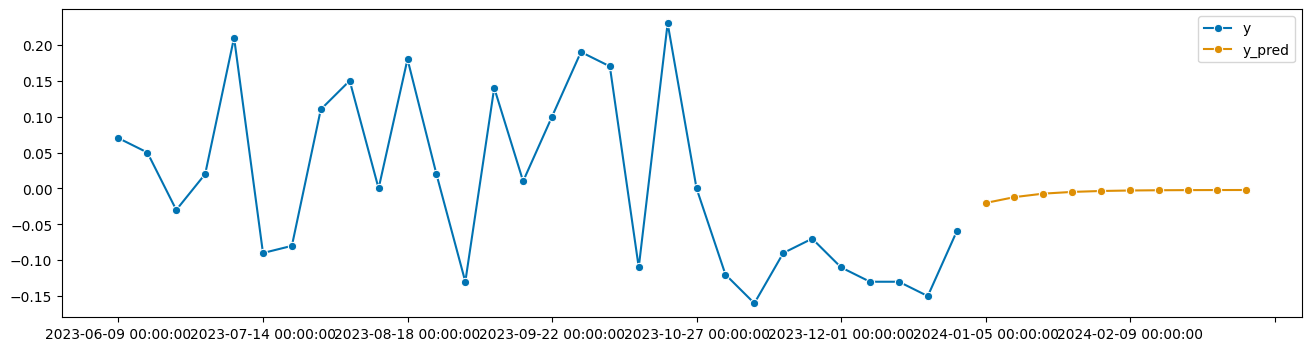

In [22]:
plot_series(y.tail(30), y_pred, labels=['y', 'y_pred'])

plt.show()

Доверительный интервал

In [23]:
conf_int = forecaster.predict_interval(fh=np.arange(1, 11), coverage=0.9)
conf_int

WGS10YR          
                 0.9          
               lower     upper
2024-01-05 -0.180925  0.140345
2024-01-12 -0.176842  0.152605
2024-01-19 -0.172194  0.157659
2024-01-26 -0.169965  0.160210
2024-02-02 -0.168696  0.161534
2024-02-09 -0.168037  0.162212
2024-02-16 -0.167686  0.162568
2024-02-23 -0.167502  0.162754
2024-03-01 -0.167405  0.162851
2024-03-08 -0.167354  0.162902

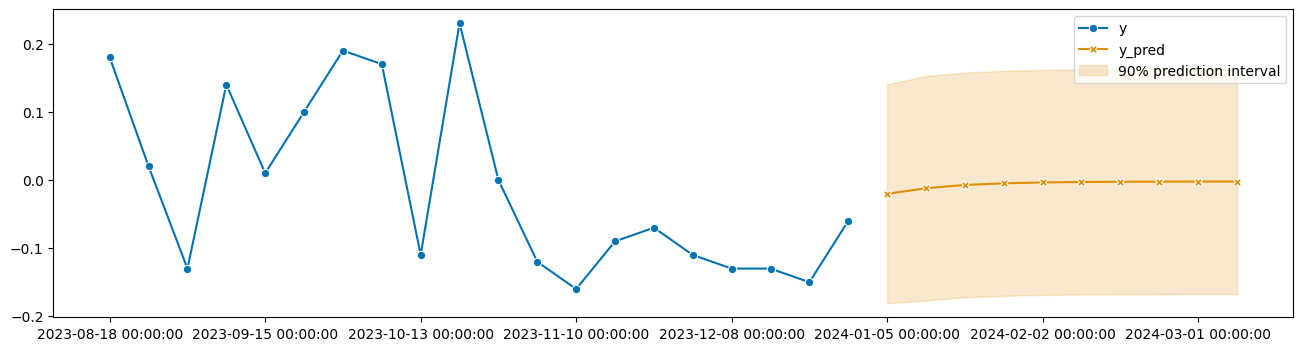

In [24]:
plot_series(y.tail(20), y_pred, labels=['y', 'y_pred'], markers=['o', 'X'], pred_interval=conf_int)

plt.show()

## Прогнозирование с ARMA ("оптимальный" порядок)

Построим прогноз для `y` на 10 периодов используя модель ARMA(p,q), "оптимальный" порядок которой выбран по информационному критерию 

In [25]:
forecaster = AutoARIMA(start_p=1, start_q=1, max_p=5, max_q=5, stationary=True, information_criterion='bic', seasonal=False)

y_pred = forecaster.fit_predict(y, fh=np.arange(1, 11))
y_pred

,WGS10YR
2024-01-05,-1.366861e-02
2024-01-12,-3.113848e-03
2024-01-19,-7.093662e-04
2024-01-26,-1.616008e-04
2024-02-02,-3.681431e-05
2024-02-09,-8.386674e-06
2024-02-16,-1.910570e-06
2024-02-23,-4.352472e-07
2024-03-01,-9.915373e-08
2024-03-08,-2.258823e-08


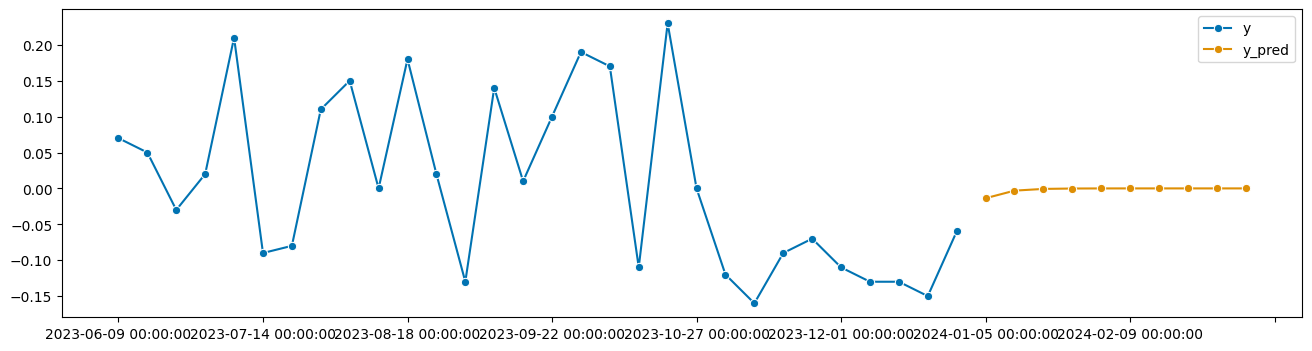

In [26]:
plot_series(y.tail(30), y_pred, labels=['y', 'y_pred'])

plt.show()

In [27]:
# параметры подогнанной модели
forecaster.get_fitted_params()

{'ar.L1': 0.2278101596961456,
 'sigma2': 0.00955960142922912,
 'order': (1, 0, 0),
 'seasonal_order': (0, 0, 0, 0),
 'aic': -2263.1672935302186,
 'aicc': -2263.1576781456033,
 'bic': -2252.9038965092846,
 'hqic': -2259.3090958249463}

## Прогнозирование с ARMA (с трендом)

Построим прогноз для `y` модель ARMA(2,1) с трендом на 10 периодов

Спецификация

$$
	y_t=\alpha_0+\alpha_1 t+\phi_1y_{t-1}+\phi_2y_{t-2}+u_1+\theta u_{t-1}
$$

In [33]:
forecaster = ARIMA(order=(2,0,2), trend='ct')
y_pred = forecaster.fit_predict(y, fh=np.arange(1, 11))
y_pred

,WGS10YR
2024-01-05,-0.012453
2024-01-12,-0.002840
2024-01-19,0.002478
2024-01-26,0.005183
2024-02-02,0.006633
2024-02-09,0.007392
2024-02-16,0.007800
2024-02-23,0.008021
2024-03-01,0.008145
2024-03-08,0.008218


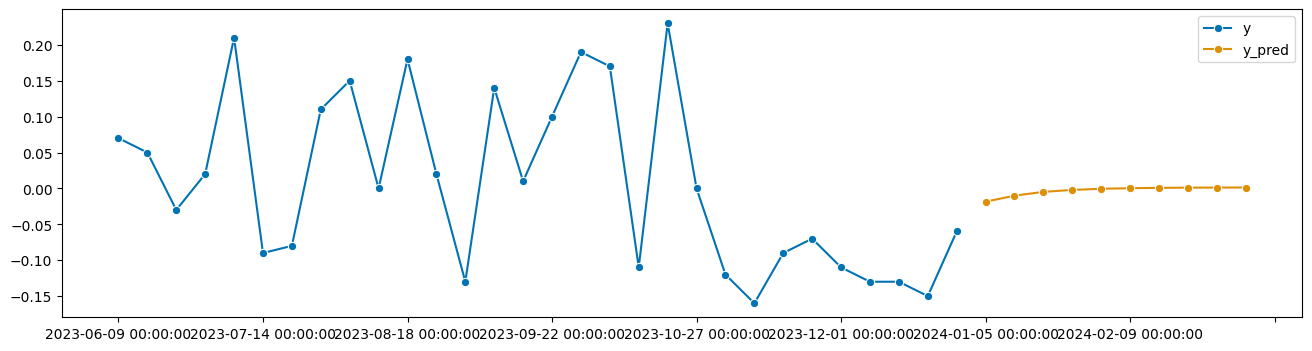

In [29]:
plot_series(y.tail(30), y_pred, labels=['y', 'y_pred'])

plt.show()